# Setup

This notebook does layerwise evaluations of large language models using a variety of evaluation metrics.
Authors: Oscar Skean

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2LMHeadModel, GPT2Model, AutoModel
from utils.misc.metric_utils import (
    compute_per_forward_pass,
    compute_on_concatenated_passes,
    metric_name_to_function
)
from utils.misc.model_dataloader_utils import model_name_to_sizes, get_model_path, get_dataloader, get_augmentation_collated_dataloader

device = "cuda:1"
DISABLE_TQDM = True

# Layerwise Evaluations

In [2]:
class ModelSpecifications:
    def __init__(self, model_family, model_size, revision):
        self.model_family = model_family
        self.model_size = model_size
        self.revision = revision

        self.do_checks()
    
    def do_checks(self):
        if self.revision != "main":
            # currently only supporting 14m and 410m Pythia models for checkpoints
            assert self.model_family == "Pythia"
            assert self.model_size in ["14m", "410m"]

        assert self.model_family in model_name_to_sizes.keys()
        assert self.model_size in model_name_to_sizes[self.model_family]

class EvaluationMetricSpecifications:
    def __init__(
        self, 
        evaluation_metric, 
        num_samples = 1000, 
        alpha = 1, 
        normalizations = ['maxEntropy', 'raw', 'logN', 'logNlogD', 'logD'],
        curvature_k = 1
    ):
        self.evaluation_metric = evaluation_metric
        self.num_samples = num_samples

        
        if self.evaluation_metric == 'sentence-entropy':
            self.granularity = 'sentence'
            self.evaluation_metric = 'entropy'
        elif self.evaluation_metric == 'dataset-entropy':
            self.granularity = 'dataset'
            self.evaluation_metric = 'entropy'
        else:
            self.granularity = None

        # for matrix-based metrics (LIDAR, DIME, entropy)
        self.normalizations = normalizations
        self.alpha = alpha

        # for curvature
        self.curvature_k = curvature_k
        
        self.do_checks()

    def do_checks(self):
        assert self.evaluation_metric in metric_name_to_function.keys()
        assert self.granularity in ['sentence', 'dataset', None]

        assert self.alpha > 0
        assert self.num_samples > 0
        assert self.curvature_k > 0 and isinstance(self.curvature_k, int)

In [3]:
def save_results(results, model_specs: ModelSpecifications, evaluation_metric_specs: EvaluationMetricSpecifications, dataloader_kwargs):
    model_family = model_specs.model_family
    model_size = model_specs.model_size
    revision = model_specs.revision
    evaluation_metric = evaluation_metric_specs.evaluation_metric
    granularity = evaluation_metric_specs.granularity
    dataset = dataloader_kwargs['dataset_name']

    if evaluation_metric == 'entropy':
        evaluation_metric = f"{evaluation_metric}_{granularity}"

    save_dir = f"results/{model_family}/{model_size}/{revision}/metrics/{dataset}/"
    os.makedirs(save_dir, exist_ok=True)
    with open(f"{save_dir}/{evaluation_metric}.pkl", "wb") as f:
        pickle.dump(results, f)
        
def load_results(model_specs: ModelSpecifications, evaluation_metric_specs: EvaluationMetricSpecifications, dataloader_kwargs):
    model_family = model_specs.model_family
    model_size = model_specs.model_size
    revision = model_specs.revision
    evaluation_metric = evaluation_metric_specs.evaluation_metric
    granularity = evaluation_metric_specs.granularity
    dataset = dataloader_kwargs['dataset_name']

    if evaluation_metric == 'entropy':
        evaluation_metric = f"{evaluation_metric}_{granularity}"

    load_dir = f"results/{model_family}/{model_size}/{revision}/metrics/{dataset}/"
    file_path = f"{load_dir}/{evaluation_metric}.pkl"

    try:
        with open(file_path, "rb") as f:
            results = pickle.load(f)
        return results
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

In [4]:
def calculate_and_save_layerwise_metrics(
    model_specs: ModelSpecifications,
    evaluation_metric_specs: EvaluationMetricSpecifications,
):
    dataloader_kwargs = {
        "dataset_name": "wikitext",
        "split": "train",
        "num_samples": 10000,
        "max_sample_length": 512 if model_specs.model_family == "bert" else 2048,
    }

    model_path = get_model_path(model_specs.model_family, model_specs.model_size)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path, 
                                      output_hidden_states=True, 
                                      torch_dtype=torch.bfloat16,
                                      revision=model_specs.revision).to(device)
    


    if evaluation_metric_specs.evaluation_metric == 'entropy':
        dataloader = get_dataloader(tokenizer, **dataloader_kwargs)
        compute_func_kwargs = {
            'alpha': evaluation_metric_specs.alpha,
            'normalizations': evaluation_metric_specs.normalizations
        }
        forward_pass_func = compute_per_forward_pass if evaluation_metric_specs.granularity == 'sentence' else compute_on_concatenated_passes
  

    elif evaluation_metric_specs.evaluation_metric == 'curvature':
        dataloader = get_dataloader(tokenizer, **dataloader_kwargs)
        compute_func_kwargs = {
            'k': evaluation_metric_specs.curvature_k
        }
        forward_pass_func = compute_per_forward_pass

    elif evaluation_metric_specs.evaluation_metric == 'lidar':
        dataloader_kwargs['num_augmentations_per_sample'] = 16
        dataloader = get_augmentation_collated_dataloader(tokenizer, **dataloader_kwargs)
        compute_func_kwargs = {
            'alpha': evaluation_metric_specs.alpha,
            'normalizations': evaluation_metric_specs.normalizations,
        }
        forward_pass_func = compute_on_concatenated_passes

    elif evaluation_metric_specs.evaluation_metric == 'dime':
        dataloader_kwargs['num_augmentations_per_sample'] = 2
        dataloader = get_augmentation_collated_dataloader(tokenizer, **dataloader_kwargs)
        compute_func_kwargs = {
            'alpha': evaluation_metric_specs.alpha,
            'normalizations': evaluation_metric_specs.normalizations,
        }
        forward_pass_func = compute_on_concatenated_passes

    elif evaluation_metric_specs.evaluation_metric == 'infonce':
        dataloader_kwargs['num_augmentations_per_sample'] = 2
        dataloader = get_augmentation_collated_dataloader(tokenizer, **dataloader_kwargs)
        compute_func_kwargs = {
            'temperature': 0.1,
        }
        forward_pass_func = compute_on_concatenated_passes

    compute_func = metric_name_to_function[evaluation_metric_specs.evaluation_metric]
    results = forward_pass_func(model, dataloader, compute_func, **compute_func_kwargs)
    save_results(results, model_specs, evaluation_metric_specs, dataloader_kwargs)


In [5]:
from itertools import product

model_names = ['Pythia']
evaluation_metrics = ['infonce', 'dime', 'lidar', 'sentence-entropy', 'dataset-entropy', 'curvature']

pythia_revision_steps = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 128000]
revisions = ['main'] + [f"step{step}" for step in pythia_revision_steps]
num_samples = 1000

for model_name, revision, evaluation_metric in product(model_names, revisions, evaluation_metrics):
    try:
        model_spec = ModelSpecifications(model_family=model_name, model_size='410m', revision=revision)
        eval_spec = EvaluationMetricSpecifications(
            evaluation_metric=evaluation_metric,
            alpha=2,
            num_samples=num_samples
        )
        
        calculate_and_save_layerwise_metrics(model_spec, eval_spec)
        
    except Exception as e:
        print(f"\tError for {model_name}, {evaluation_metric}, {revision}: {str(e)}")

/home/AD/ofsk222/miniconda3/envs/information_plane/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|█████████▉| 999/1000 [00:48<00:00, 20.65it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|█████████▉| 999/1000 [00:47<00:00, 21.05it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
 10%|▉         | 95/1000 [00:35<05:39,  2.67it/s]


KeyboardInterrupt: 

# Small Plots

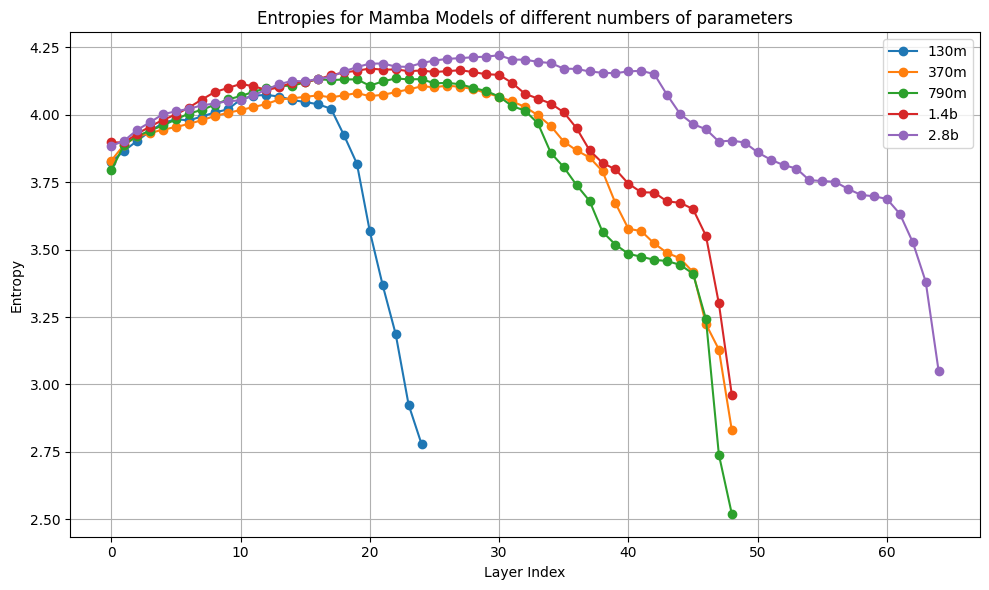

In [ ]:
import matplotlib.pyplot as plt

layerwise_entropies = load_results_layerwise_entropies("mamba", 'alpha1', granularity='sentence', normalization='raw')

fig, ax = plt.subplots(figsize=(10, 6))

for model_family, entropies in layerwise_entropies.items():
    ax.plot(entropies, marker='o', label=model_family)

ax.set_title('Entropies for Mamba Models of different numbers of parameters')
ax.set_xlabel('Layer Index')
ax.set_ylabel('Entropy')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

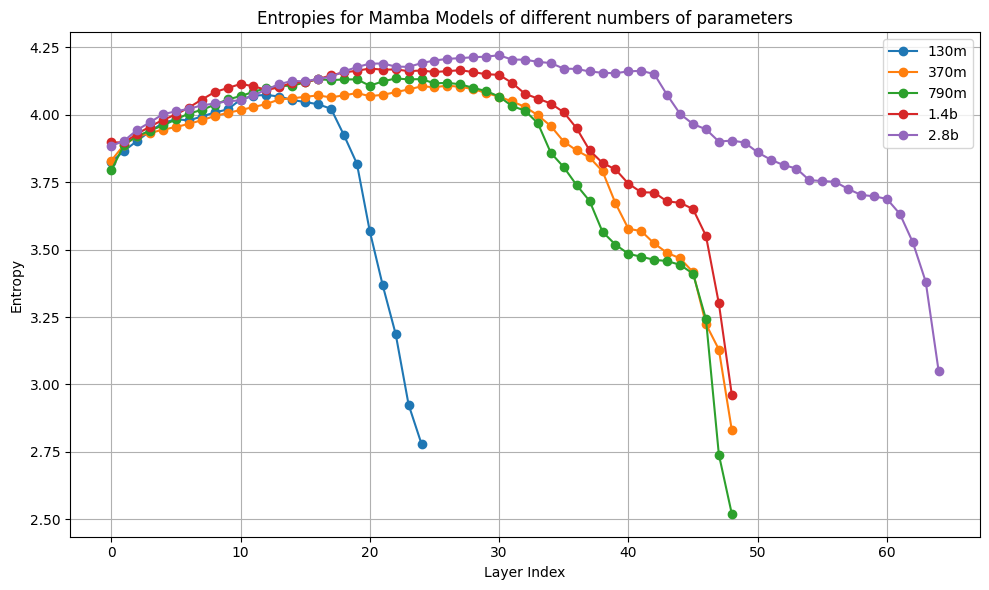

In [ ]:
import matplotlib.pyplot as plt

layerwise_entropies = load_results_layerwise_entropies("mamba", 'alpha1', granularity='sentence', normalization='raw')

fig, ax = plt.subplots(figsize=(10, 6))

for model_family, entropies in layerwise_entropies.items():
    ax.plot(entropies, marker='o', label=model_family)

ax.set_title('Entropies for Mamba Models of different numbers of parameters')
ax.set_xlabel('Layer Index')
ax.set_ylabel('Entropy')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

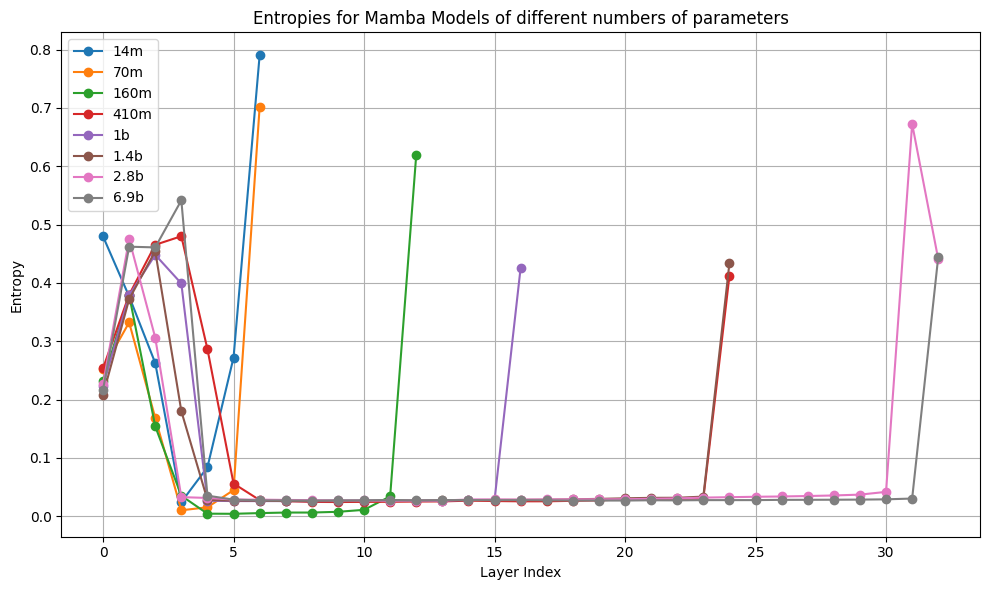

In [ ]:
import matplotlib.pyplot as plt

layerwise_entropies = load_results_layerwise_entropies("EleutherAI", 'alpha1', granularity='dataset', normalization='maxEntropy')

fig, ax = plt.subplots(figsize=(10, 6))

for model_family, entropies in layerwise_entropies.items():
    ax.plot(entropies, marker='o', label=model_family)

ax.set_title('Entropies for Mamba Models of different numbers of parameters')
ax.set_xlabel('Layer Index')
ax.set_ylabel('Entropy')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with a subplot for each model
num_models = len(layerwise_entropies_per_model)
fig, axs = plt.subplots(num_models, 1, figsize=(8, 3 * num_models), sharex=True)

all_entropies = [entropy for entropies in layerwise_entropies_per_model.values() for entropy in entropies]
y_min, y_max = min(all_entropies), max(all_entropies)

# Flatten axs if there is only one subplot
if num_models == 1:
    axs = [axs]

# Plot each model's data
for ax, (model_family, entropies) in zip(axs, layerwise_entropies_per_model.items()):
    ax.plot(entropies, marker='o')
    ax.set_title(f'Entropies for {model_family}')
    ax.set_ylabel('Entropy')
    ax.set_ylim(y_min*0.95, y_max*1.05)
    ax.grid(True)

# Set common x-axis label
axs[-1].set_xlabel('Layer Index')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

NameError: name 'layerwise_entropies_per_model' is not defined

## Data Augmentation

In [1]:
from utils import text_augmentation

input_text = ["The quick brown fox jumps over the lazy dog."]

augmented_text = text_augmentation(input_text, num_augmentations_per_sample=10)
print(f"Original text: {input_text}")
for i, t in enumerate(augmented_text[0].split(',')):
    print(f"Augmented text {i}: {t}")

Original text: ['The quick brown fox jumps over the lazy dog.']
Augmented text 0: ['The q 8ecU b rfBg fox j uHem oSe! the lQz5 dog.'
Augmented text 1:  'The qu ick b Co#p fox P*mks o ver the gFzH dog.'
Augmented text 2:  'The qGiBI HUo3n fox jum ps o ver the la zy dog.'
Augmented text 3:  'The q uJ)Q bro wn fox ju mps oF2$ the l1x0 dog.'
Augmented text 4:  'The q&Jfk b r + wz fox jum ps o ver the lSay dog.'
Augmented text 5:  'The q V&cd br own fox jum ps Xve # the & az (dog.'
Augmented text 6:  'The qu ick bAoQS fox jum ps * vea the la zy dog.'
Augmented text 7:  'The qu ick b & 2wn fox jxbpx dcwr the la zy dog.'
Augmented text 8:  'The q u @ zk b # dwn fox j f<pd ov er the T0ay dog.'
Augmented text 9:  'The !uZXf bro wn fox jum ps M7eF the l azy dog.']


# Plotting

[Errno 2] No such file or directory: 'entropy_results/entropy=dime_model=bert_granularity=dataset_normalization=maxEntropy.pkl'


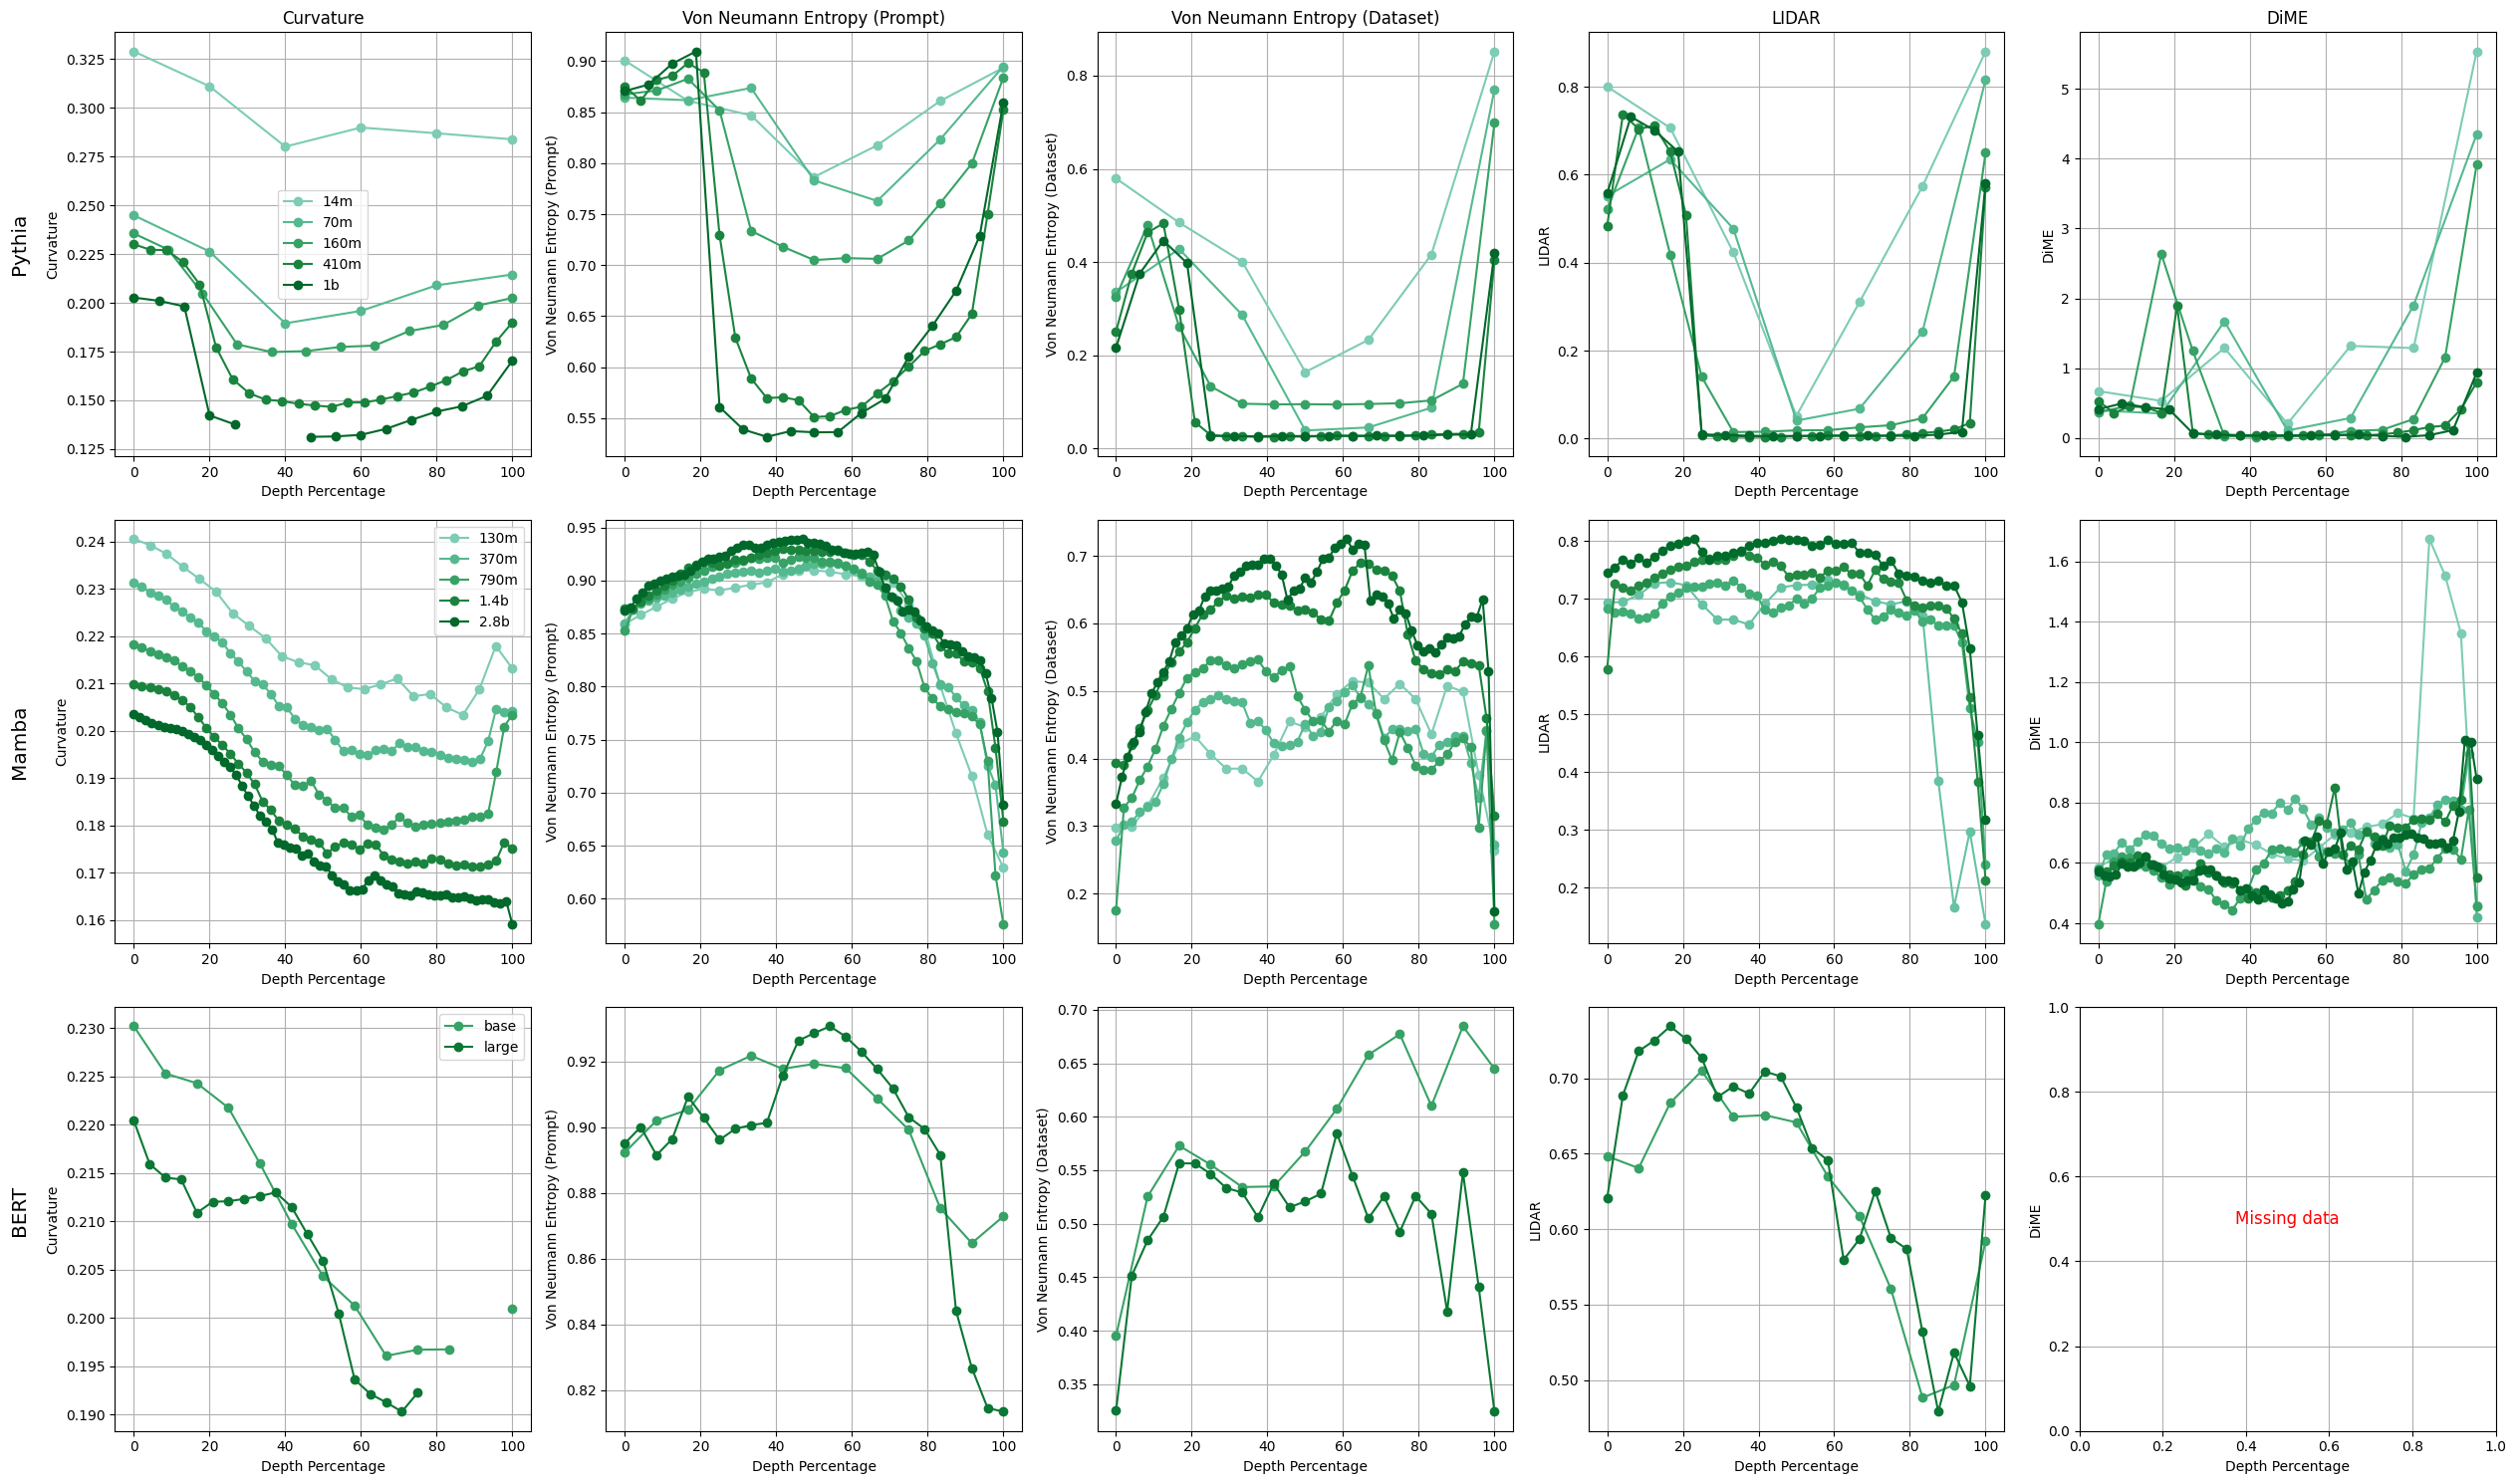

In [6]:
import matplotlib.pyplot as plt
import pickle

def load_results_layerwise_entropies(model_name, experiment_name, granularity, normalization):
    with open(f"entropy_results/entropy={experiment_name}_model={model_name}_granularity={granularity}_normalization={normalization}.pkl", "rb") as f:
        layerwise_entropies_per_model = pickle.load(f)
    return layerwise_entropies_per_model

SHOULD_USE_DEPTH_PERCENTAGE =True 


models = ["EleutherAI", "mamba", "bert"] 
experiments = ["curvature", "entropy", "entropy","lidar", "dime"]

A = len(models)
B = len(experiments)
fig, axs = plt.subplots(A, B, figsize=(5 * B, 5 * A))

row_labels = ['Pythia', 'Mamba', 'BERT']
col_labels = ['Curvature', 'Von Neumann Entropy (Prompt)', 'Von Neumann Entropy (Dataset)', 'LIDAR', 'DiME']

# Iterate over models and experiments
for i, model_family in enumerate(models):
    for j, evaluation_metric in enumerate(experiments):
        # Load entropies for each model and experiment
        granularity = 'sentence' if 'entropy' in evaluation_metric and j==1 else 'dataset'
        granularity = 'sentence' if 'curvature' in evaluation_metric else granularity

        normalization = 'maxEntropy'
        normalization = 'raw' if 'curvature' in evaluation_metric else normalization

        try:
            layerwise_entropies = load_results_layerwise_entropies(model_family, evaluation_metric, granularity=granularity, normalization=normalization)
        except FileNotFoundError as e:
            print(e)
            layerwise_entropies=None

        # Access the corresponding subplot
        ax = axs[i, j] if A > 1 and B > 1 else axs[j] if A == 1 else axs[i]

        if layerwise_entropies is not None:
            # for pythia, only plot 1B and 1.4B models
            if model_family == "EleutherAI":
                layerwise_entropies = {k: v for k, v in layerwise_entropies.items() if k not in ['1.4b', '2.8b', '6.9b']}
            for model_size_idx, (model_variant, entropies) in enumerate(layerwise_entropies.items()):
                offset = 4
                color = plt.cm.BuGn( (model_size_idx+offset) / (len(layerwise_entropies) + offset) )

                if SHOULD_USE_DEPTH_PERCENTAGE:
                    depth_percentage = np.linspace(0, 100, len(entropies))
                    ax.plot(depth_percentage, entropies, marker='o', label=model_variant, color=color)
                else:
                    ax.plot(entropies, marker='o', label=model_variant, color=color)
        else:
            ax.text(0.5, 0.5, 'Missing data', ha='center', va='center', fontsize=12, color='red')

        if SHOULD_USE_DEPTH_PERCENTAGE:
            ax.set_xlabel('Depth Percentage')
        else:   
            ax.set_xlabel('Layer')
        ax.set_ylabel(f'{col_labels[j]}')
        if i==0:
            ax.set_title(f'{col_labels[j]}')
        
        if j == 0:
            ax.legend()
        ax.grid(True)
# Set row labels using ax.text
for i, row in enumerate(row_labels):
    y_position = (A-i-0.5)/A
    if i == len(models)-1:
        y_position += 0.02
    fig.text(-0.001, y_position, row, rotation=90, va='center', ha='right', fontsize='x-large')

# Adjust layout
plt.tight_layout()
plt.show()

# Plot Normalizations

Error loading data for logD normalization: [Errno 2] No such file or directory: 'entropy_results/entropy=entropy_model=mamba_granularity=sentence_normalization=logD.pkl'


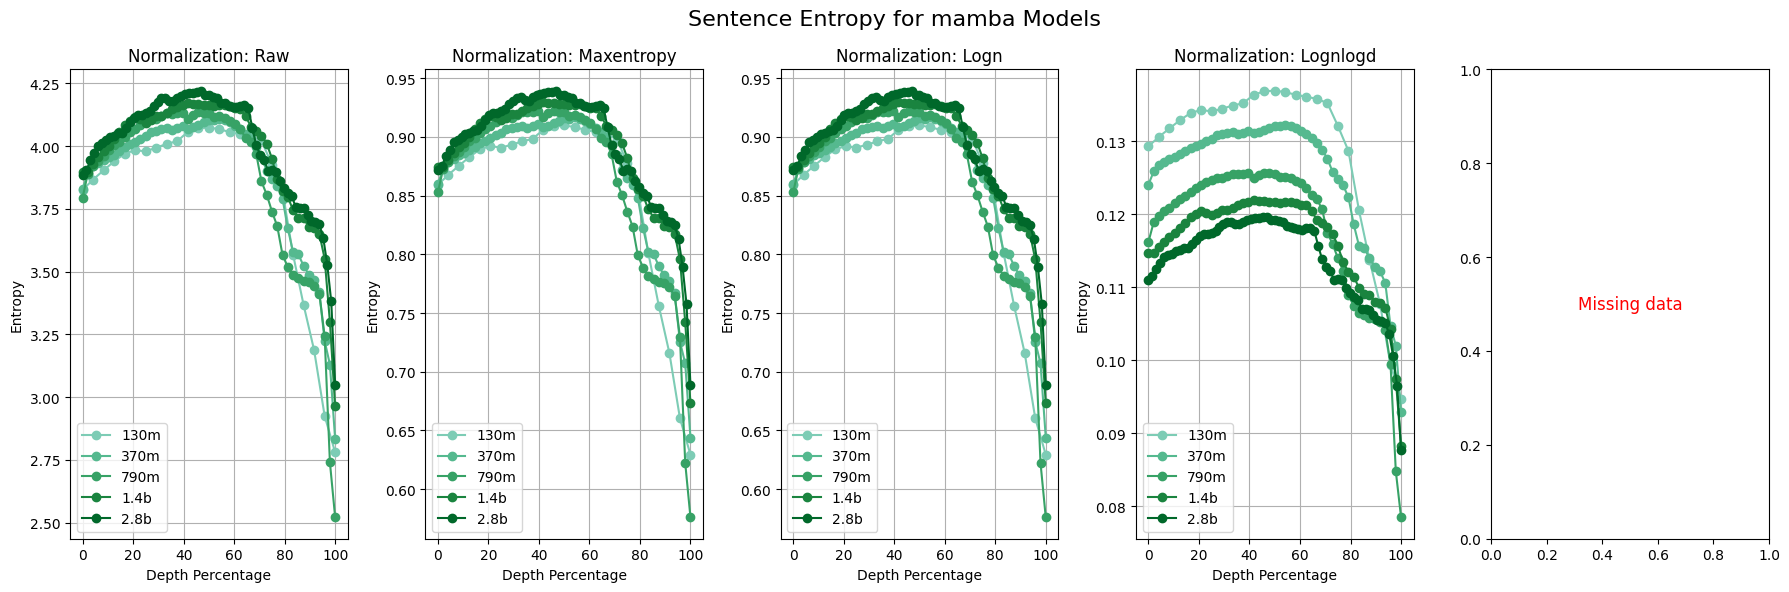

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Define the normalizations and Pythia model sizes
normalizations = ['raw', 'maxEntropy', 'logN', 'logNlogD', 'logD']
pythia_sizes = ['1b', '1.4b', '2.8b', '6.9b']
model_type = "mamba"

# Create a figure with subplots for each normalization
fig, axs = plt.subplots(1, len(normalizations), figsize=(18, 6))
fig.suptitle(f'Sentence Entropy for {model_type} Models', fontsize=16)

for i, normalization in enumerate(normalizations):
    try:
        layerwise_entropies = load_results_layerwise_entropies(model_type, "entropy", granularity="sentence", normalization=normalization)
       
        
        for model_size_idx, (model_variant, entropies) in enumerate(layerwise_entropies.items()):
            offset = 4
            color = plt.cm.BuGn((model_size_idx + offset) / (len(layerwise_entropies) + offset))
            
            if SHOULD_USE_DEPTH_PERCENTAGE:
                depth_percentage = np.linspace(0, 100, len(entropies))
                axs[i].plot(depth_percentage, entropies, marker='o', label=model_variant, color=color)
            else:
                axs[i].plot(entropies, marker='o', label=model_variant, color=color)
        
        axs[i].set_title(f'Normalization: {normalization.capitalize()}')
        axs[i].set_xlabel('Depth Percentage' if SHOULD_USE_DEPTH_PERCENTAGE else 'Layer')
        axs[i].set_ylabel('Entropy')
        axs[i].legend()
        axs[i].grid(True)
    
    except FileNotFoundError as e:
        print(f"Error loading data for {normalization} normalization: {e}")
        axs[i].text(0.5, 0.5, 'Missing data', ha='center', va='center', fontsize=12, color='red')

plt.tight_layout()
plt.show()

# Model Checkpoints

In [22]:
def load_results_layerwise_entropies(model_name, experiment_name, granularity, normalization, revisioned=False):
    try:
        revisioned_suffix = "_revisioned410" if revisioned else ""
        file_path = f"entropy_results/entropy={experiment_name}_model={model_name}_granularity={granularity}_normalization={normalization}{revisioned_suffix}.pkl"
        
        with open(file_path, "rb") as f:
            layerwise_entropies_per_model = pickle.load(f)
        
        return layerwise_entropies_per_model
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

/tmp/ipykernel_215305/1498876292.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greens').copy()


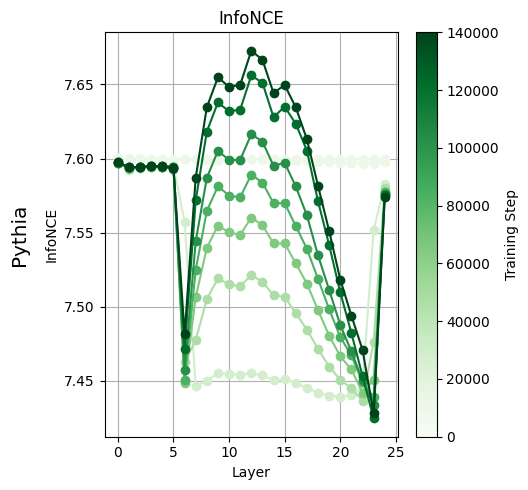

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

SHOULD_USE_DEPTH_PERCENTAGE = False

models = ["EleutherAI"]
experiments = ["infonce"]

A = len(models)
B = len(experiments)
fig, axs = plt.subplots(A, B, figsize=(5 * B, 5 * A))
if A == 1:
    axs = [axs]

row_labels = ['Pythia']
col_labels = ['InfoNCE']

# Iterate over models and experiments
for i, model_family in enumerate(models):
    for j, evaluation_metric in enumerate(experiments):
        # Load entropies for each model and experiment
        granularity = 'dataset'

        normalization = 'logNlogD'
        normalization = 'raw' if 'curvature' in evaluation_metric else normalization
        normalization = 'raw' if 'infonce' in evaluation_metric else normalization
        normalization = 'maxEntropy' if 'lidar' in evaluation_metric else normalization

        layerwise_entropies = load_results_layerwise_entropies(model_family, evaluation_metric, granularity=granularity, normalization=normalization, revisioned=True)

        # Access the corresponding subplot
        ax = axs[i, j] if A > 1 and B > 1 else axs[j] if A == 1 else axs[i]
        if layerwise_entropies is not None:
            for model_size_idx, (model_variant, entropies) in enumerate(layerwise_entropies.items()):
                step = int(model_variant.split('_step')[1])
                color = plt.cm.Greens((10000+step) / 150000)  # Normalize step to [0, 1]

                if SHOULD_USE_DEPTH_PERCENTAGE:
                    depth_percentage = np.linspace(0, 100, len(entropies))
                    ax.plot(depth_percentage, entropies, marker='o', color=color)
                else:
                    ax.plot(entropies, marker='o', color=color)
        else:
            ax.text(0.5, 0.5, 'Missing data', ha='center', va='center', fontsize=12, color='red')

        if SHOULD_USE_DEPTH_PERCENTAGE:
            ax.set_xlabel('Depth Percentage')
        else:   
            ax.set_xlabel('Layer')
        ax.set_ylabel(f'{col_labels[j]}')
        if i==0:
            ax.set_title(f'{col_labels[j]}')
        
        ax.grid(True)

        # Add colorbar as legend
        cmap = plt.cm.get_cmap('Greens').copy()
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=140000))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Training Step')

# Set row labels using ax.text
for i, row in enumerate(row_labels):
    y_position = (A-i-0.5)/A
    if i == len(models)-1:
        y_position += 0.02
    fig.text(-0.001, y_position, row, rotation=90, va='center', ha='right', fontsize='x-large')

# Adjust layout
plt.tight_layout()
plt.show()

/tmp/ipykernel_215305/2714224157.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greens').copy()


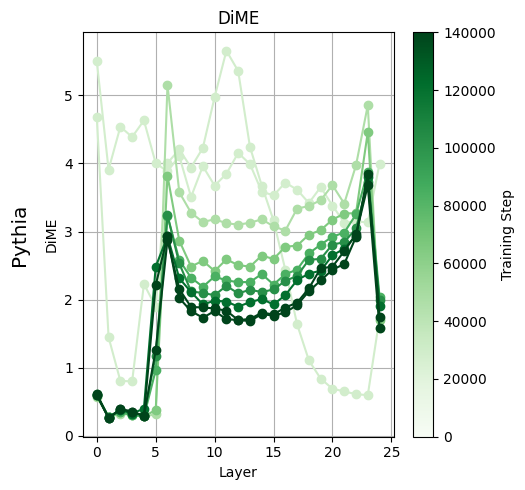

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

SHOULD_USE_DEPTH_PERCENTAGE = False

models = ["EleutherAI"]
experiments = ["dime"]

A = len(models)
B = len(experiments)
fig, axs = plt.subplots(A, B, figsize=(5 * B, 5 * A))
if A == 1:
    axs = [axs]

row_labels = ['Pythia']
col_labels = ['DiME']

# Iterate over models and experiments
for i, model_family in enumerate(models):
    for j, evaluation_metric in enumerate(experiments):
        # Load entropies for each model and experiment
        granularity = 'dataset'

        normalization = 'raw'
        normalization = 'raw' if 'curvature' in evaluation_metric else normalization
        normalization = 'raw' if 'infonce' in evaluation_metric else normalization
        normalization = 'maxEntropy' if 'lidar' in evaluation_metric else normalization

        layerwise_entropies = load_results_layerwise_entropies(model_family, evaluation_metric, granularity=granularity, normalization=normalization, revisioned=True)

        # Access the corresponding subplot
        ax = axs[i, j] if A > 1 and B > 1 else axs[j] if A == 1 else axs[i]
        if layerwise_entropies is not None:
            for model_size_idx, (model_variant, entropies) in enumerate(layerwise_entropies.items()):
                step = int(model_variant.split('_step')[1])
                color = plt.cm.Greens((30000+step) / 150000)  # Normalize step to [0, 1]

                if SHOULD_USE_DEPTH_PERCENTAGE:
                    depth_percentage = np.linspace(0, 100, len(entropies))
                    ax.plot(depth_percentage, entropies, marker='o', color=color)
                else:
                    ax.plot(entropies, marker='o', color=color)
        else:
            ax.text(0.5, 0.5, 'Missing data', ha='center', va='center', fontsize=12, color='red')

        if SHOULD_USE_DEPTH_PERCENTAGE:
            ax.set_xlabel('Depth Percentage')
        else:   
            ax.set_xlabel('Layer')
        ax.set_ylabel(f'{col_labels[j]}')
        if i==0:
            ax.set_title(f'{col_labels[j]}')
        
        ax.grid(True)

        # Add colorbar as legend
        cmap = plt.cm.get_cmap('Greens').copy()
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=140000))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Training Step')

# Set row labels using ax.text
for i, row in enumerate(row_labels):
    y_position = (A-i-0.5)/A
    if i == len(models)-1:
        y_position += 0.02
    fig.text(-0.001, y_position, row, rotation=90, va='center', ha='right', fontsize='x-large')

# Adjust layout
plt.tight_layout()
plt.show()

In [33]:
entropy_results = load_results_layerwise_entropies("EleutherAI", "entropy", granularity="sentence", normalization="logN")
entropy_results = entropy_results['410m']
print(entropy_results)

[0.8752998  0.86130982 0.88152474 0.8856587  0.89816086 0.88909957
 0.72936301 0.62901308 0.58900564 0.5697093  0.57059313 0.56770401
 0.55115733 0.55202105 0.55815219 0.56141195 0.57417122 0.5861448
 0.60052457 0.61599036 0.62249576 0.62953523 0.65215897 0.75019682
 0.85229325]


File not found: entropy_results/entropy=dime_model=EleutherAI_granularity=sentence_normalization=raw.pkl


/tmp/ipykernel_215305/3399762837.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greens').copy()


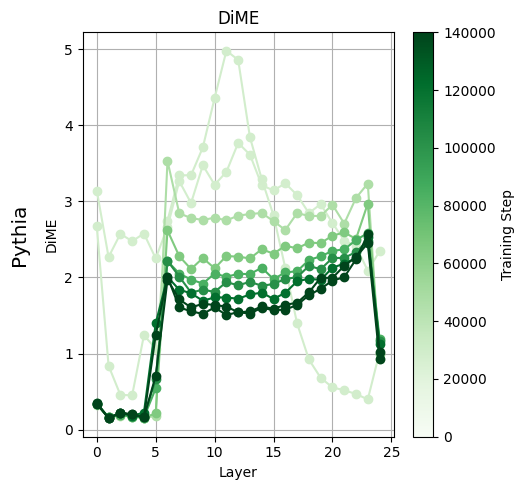

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

SHOULD_USE_DEPTH_PERCENTAGE = False

models = ["EleutherAI"]
experiments = ["dime"]

A = len(models)
B = len(experiments)
fig, axs = plt.subplots(A, B, figsize=(5 * B, 5 * A))
if A == 1:
    axs = [axs]


dime_results = load_results_layerwise_entropies("EleutherAI", "dime", granularity="sentence", normalization="raw")

row_labels = ['Pythia']
col_labels = ['DiME']

# Iterate over models and experiments
for i, model_family in enumerate(models):
    for j, evaluation_metric in enumerate(experiments):
        # Load entropies for each model and experiment
        granularity = 'dataset'

        normalization = 'raw'
        normalization = 'raw' if 'curvature' in evaluation_metric else normalization
        normalization = 'raw' if 'infonce' in evaluation_metric else normalization
        normalization = 'maxEntropy' if 'lidar' in evaluation_metric else normalization

        layerwise_entropies = load_results_layerwise_entropies(model_family, evaluation_metric, granularity=granularity, normalization=normalization, revisioned=True)

        # Access the corresponding subplot
        ax = axs[i, j] if A > 1 and B > 1 else axs[j] if A == 1 else axs[i]
        if layerwise_entropies is not None:
            for model_size_idx, (model_variant, entropies) in enumerate(layerwise_entropies.items()):
                step = int(model_variant.split('_step')[1])
                color = plt.cm.Greens((30000+step) / 150000)  # Normalize step to [0, 1]


                entropies /= (2*entropy_results)**1

                if SHOULD_USE_DEPTH_PERCENTAGE:
                    depth_percentage = np.linspace(0, 100, len(entropies))
                    ax.plot(depth_percentage, entropies, marker='o', color=color)
                else:
                    ax.plot(entropies, marker='o', color=color)
        else:
            ax.text(0.5, 0.5, 'Missing data', ha='center', va='center', fontsize=12, color='red')

        if SHOULD_USE_DEPTH_PERCENTAGE:
            ax.set_xlabel('Depth Percentage')
        else:   
            ax.set_xlabel('Layer')
        ax.set_ylabel(f'{col_labels[j]}')
        if i==0:
            ax.set_title(f'{col_labels[j]}')
        
        ax.grid(True)

        # Add colorbar as legend
        cmap = plt.cm.get_cmap('Greens').copy()
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=140000))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Training Step')

# Set row labels using ax.text
for i, row in enumerate(row_labels):
    y_position = (A-i-0.5)/A
    if i == len(models)-1:
        y_position += 0.02
    fig.text(-0.001, y_position, row, rotation=90, va='center', ha='right', fontsize='x-large')

# Adjust layout
plt.tight_layout()
plt.show()

In [42]:
 (entropy_results)

array([0.8752998 , 0.86130982, 0.88152474, 0.8856587 , 0.89816086,
       0.88909957, 0.72936301, 0.62901308, 0.58900564, 0.5697093 ,
       0.57059313, 0.56770401, 0.55115733, 0.55202105, 0.55815219,
       0.56141195, 0.57417122, 0.5861448 , 0.60052457, 0.61599036,
       0.62249576, 0.62953523, 0.65215897, 0.75019682, 0.85229325])